# Скачать с кэггл

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

In [ ]:
!unzip /content/dogs-vs-cats-redux-kernels-edition.zip

In [ ]:
!unzip test.zip
!unzip train.zip

In [16]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

Используется устройство: cuda


 10%|█         | 1/10 [01:29<13:24, 89.42s/it]

Epoch [1/10], Loss: 0.6174, Acc: 0.6532 | Val Loss: 0.5578, Val Acc: 0.7202


 20%|██        | 2/10 [02:56<11:45, 88.13s/it]

Epoch [2/10], Loss: 0.5316, Acc: 0.7357 | Val Loss: 0.5143, Val Acc: 0.7484


 30%|███       | 3/10 [04:24<10:16, 88.05s/it]

Epoch [3/10], Loss: 0.4871, Acc: 0.7681 | Val Loss: 0.4935, Val Acc: 0.7604


 40%|████      | 4/10 [05:52<08:48, 88.13s/it]

Epoch [4/10], Loss: 0.4524, Acc: 0.7897 | Val Loss: 0.4647, Val Acc: 0.7736


 50%|█████     | 5/10 [07:21<07:20, 88.14s/it]

Epoch [5/10], Loss: 0.4227, Acc: 0.8054 | Val Loss: 0.4613, Val Acc: 0.7752


 60%|██████    | 6/10 [08:48<05:51, 87.96s/it]

Epoch [6/10], Loss: 0.3986, Acc: 0.8227 | Val Loss: 0.4326, Val Acc: 0.8022


 70%|███████   | 7/10 [10:16<04:23, 87.82s/it]

Epoch [7/10], Loss: 0.3768, Acc: 0.8315 | Val Loss: 0.4273, Val Acc: 0.8042


 80%|████████  | 8/10 [11:47<02:57, 88.99s/it]

Epoch [8/10], Loss: 0.3541, Acc: 0.8455 | Val Loss: 0.4700, Val Acc: 0.7808


 90%|█████████ | 9/10 [13:15<01:28, 88.77s/it]

Epoch [9/10], Loss: 0.3361, Acc: 0.8554 | Val Loss: 0.4314, Val Acc: 0.7992


100%|██████████| 10/10 [14:43<00:00, 88.37s/it]

Epoch [10/10], Loss: 0.3179, Acc: 0.8646 | Val Loss: 0.4015, Val Acc: 0.8170


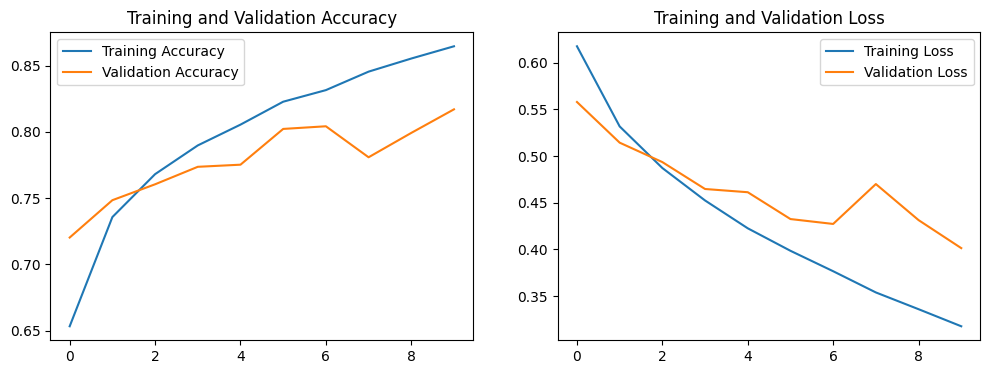

In [19]:
# Устройство: GPU или CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Используется устройство: {device}')

# 2. Подготовка DataFrame
train_dir = 'data/train'
filenames = os.listdir(train_dir)
categories = ['dog' in filename for filename in filenames]

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Разделение на обучающую и валидационную выборки
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Dataset
class CatsDogsDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = int(self.df.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# 4. Трансформации
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Датасеты и загрузчики
train_dataset = CatsDogsDataset(train_df, train_dir, transform=transform)
valid_dataset = CatsDogsDataset(valid_df, train_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# 5. Модель CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Вычислим размер после прохождения через features
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 150, 150)
            dummy_out = self.features(dummy)
            flat_size = dummy_out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

model = SimpleCNN().to(device)

# 6. Loss и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 7. Обучение модели
def train_model(model, num_epochs=10):
    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(inputs).flatten()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = accuracy_score(all_labels, all_preds)

        # Валидация
        model.eval()
        val_running_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                outputs = model(inputs).flatten()
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                preds = (outputs > 0.5).int()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(valid_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    return history

# Запуск обучения
history = train_model(model, num_epochs=10)

# 8. Визуализация результатов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
import glob
from PIL import Image

# Путь к вашим изображениям
test_images_dir = 'test'  # замените на путь к вашей папке
image_paths = glob.glob(os.path.join(test_images_dir, '*'))  # получаем все изображения из папки

# Трансформации (должны быть такими же, как при обучении)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Переводим модель в режим оценки
model.eval()

# Функция для предсказания
def predict_image(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # добавляем batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0

    return probability, prediction

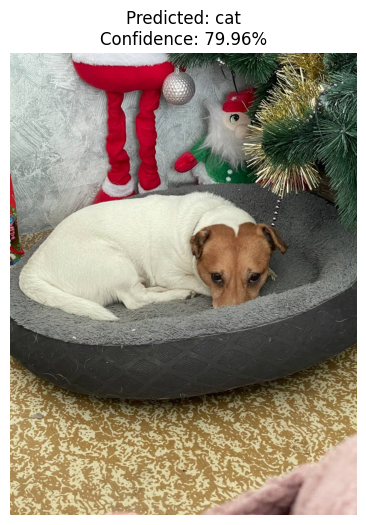

Image: 2025-06-09 00.02.46.jpg
Predicted class: cat (probability: 0.7996)
---


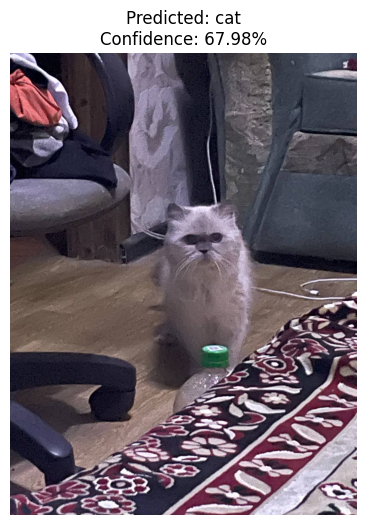

Image: 2025-06-09 00.02.04.jpg
Predicted class: cat (probability: 0.6798)
---


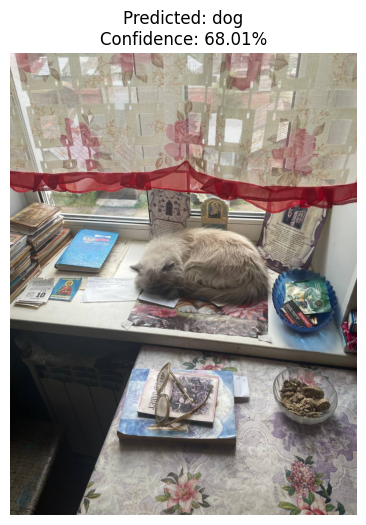

Image: 2025-06-09 00.02.36.jpg
Predicted class: dog (probability: 0.6801)
---


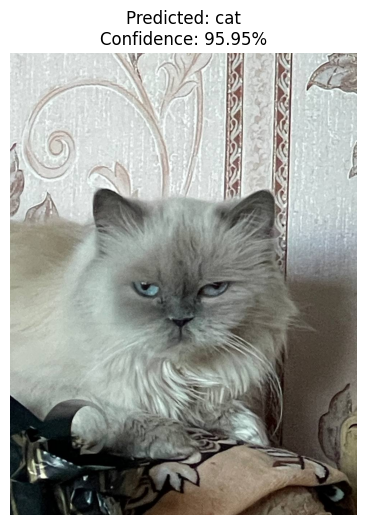

Image: 2025-06-09 00.02.26.jpg
Predicted class: cat (probability: 0.9595)
---


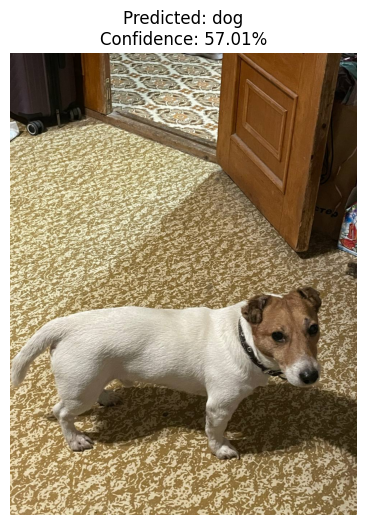

Image: 2025-06-09 00.02.43.jpg
Predicted class: dog (probability: 0.5701)
---


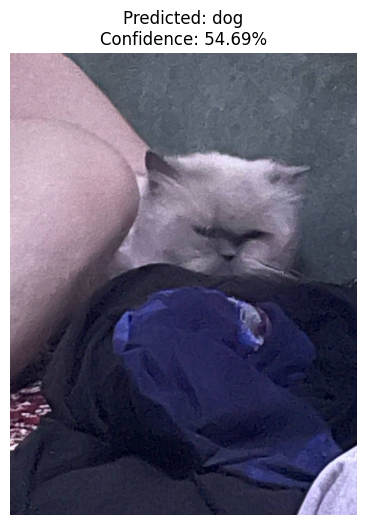

Image: 2025-06-09 00.02.30.jpg
Predicted class: dog (probability: 0.5469)
---


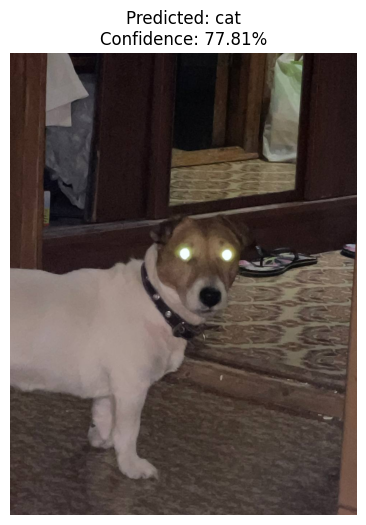

Image: 2025-06-09 00.02.50.jpg
Predicted class: cat (probability: 0.7781)
---


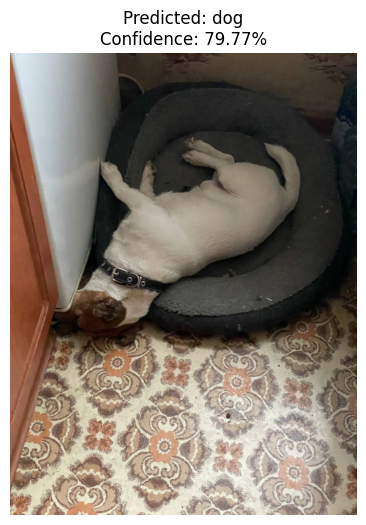

Image: 2025-06-09 00.02.40.jpg
Predicted class: dog (probability: 0.7977)
---


In [23]:
import matplotlib.pyplot as plt

def show_prediction(image_path, model, transform):
    # Получаем предсказание
    prob, pred = predict_image(image_path, model, transform)
    class_name = 'dog' if pred == 1 else 'cat'
    confidence = prob if pred == 1 else 1 - prob

    # Загружаем изображение
    image = Image.open(image_path)

    # Создаем график
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {class_name}\nConfidence: {confidence:.2%}')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Прогоняем все изображения через модель и показываем результаты
for image_path in image_paths:
    class_name, confidence = show_prediction(image_path, model, transform)
    print(f'Image: {os.path.basename(image_path)}')
    print(f'Predicted class: {class_name} (probability: {confidence:.4f})')
    print('---')